#### 1. Imports

In [1]:
from pathlib import Path
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
from sklearn.gaussian_process.kernels import Matern, WhiteKernel
from scipy.stats import qmc, norm

import matplotlib.pyplot as plt
import seaborn as sns



#### 2. Paths & Data loading

In [2]:
# --- Paths ---

BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR.parent / "initial_data" / "function_6"

# --- Load initial data ---
X = np.load(DATA_DIR / "initial_inputs.npy", allow_pickle=True)
y = np.load(DATA_DIR / "initial_outputs.npy", allow_pickle=True).ravel()
X = np.asarray(X, float)
y = np.asarray(y, float)
print(f"Loaded X:{X.shape}, y:{y.shape}")

Loaded X:(20, 5), y:(20,)


#### 3. Add weekly data

In [3]:
# --- Weekly results ---

week_data = [
    (np.array([0.471095, 0.223517, 0.632662, 0.959010, 0.000704]), -0.5417837702081443),  # W1
    (np.array([0.41723 , 0.192026, 0.747316, 0.983725, 0.001043]),  -0.5865422839076195), # W2
    (np.array([0.519632, 0.356784, 0.660361, 0.981270, 0.172574]),  -0.37445265358443836), # W3
    (np.array([0.454867, 0.217166, 0.659962, 0.973824, 0.304771]),  -0.6576217023348437), # W4
    (np.array([0.542459, 0.434923, 0.820783, 0.900865, 0.023391]),  -0.5202462131962752), # W5
    (np.array([0.428410, 0.541621, 0.481953, 0.991675, 0.152946]),  -0.5539288237668041), # W6
    (np.array([0.549782, 0.393697, 0.580699, 0.998219, 0.052892]),  -0.5208720844436923), # W7
]

X_prev, y_prev = X.copy(), y.copy()

for x_new, y_new in week_data:
    X = np.vstack([X, x_new])
    y = np.append(y, y_new)

print(f"Updated shapes → X:{X.shape}, y:{y.shape}")

Updated shapes → X:(27, 5), y:(27,)


#### 4. Quick Visualization

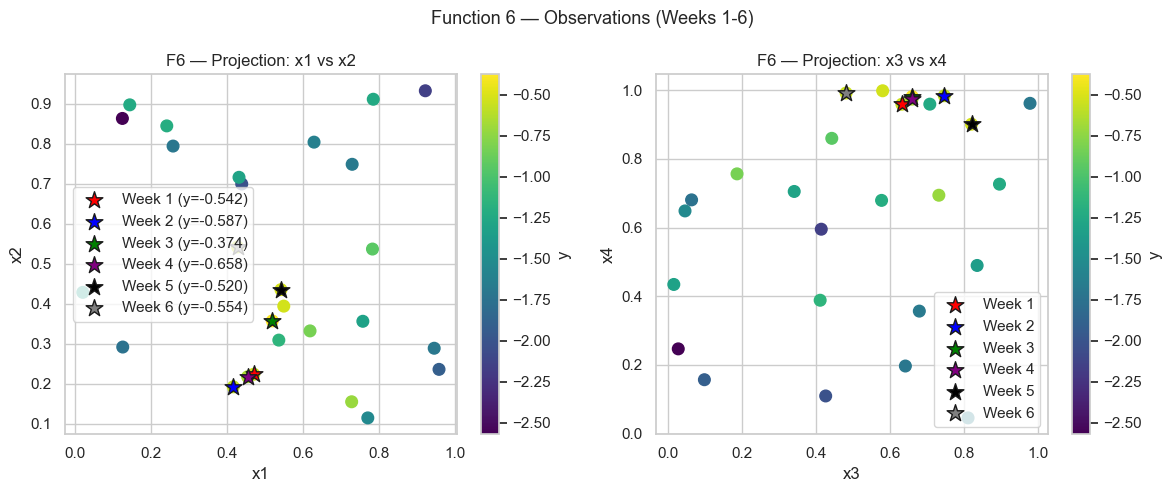

In [4]:
sns.set(style="whitegrid")

# Common color scale across all points
vmin, vmax = np.min(y), np.max(y)

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# --- Projection 1: x1 vs x2 ---
sc1 = axes[0].scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=70, vmin=vmin, vmax=vmax)
axes[0].scatter(week_data[0][0][0], week_data[0][0][1], c='red',   s=160, marker='*', edgecolors='k', label=f'Week 1 (y={week_data[0][1]:.3f})')
axes[0].scatter(week_data[1][0][0], week_data[1][0][1], c='blue',  s=160, marker='*', edgecolors='k', label=f'Week 2 (y={week_data[1][1]:.3f})')
axes[0].scatter(week_data[2][0][0], week_data[2][0][1], c='green', s=160, marker='*', edgecolors='k', label=f'Week 3 (y={week_data[2][1]:.3f})')
axes[0].scatter(week_data[3][0][0], week_data[3][0][1], c='purple', s=160, marker='*', edgecolors='k', label=f'Week 4 (y={week_data[3][1]:.3f})')
axes[0].scatter(week_data[4][0][0], week_data[4][0][1], c='black', s=160, marker='*', edgecolors='k', label=f'Week 5 (y={week_data[4][1]:.3f})')
axes[0].scatter(week_data[5][0][0], week_data[5][0][1], c='grey', s=160, marker='*', edgecolors='k', label=f'Week 6 (y={week_data[5][1]:.3f})')
axes[0].set_xlabel('x1'); axes[0].set_ylabel('x2')
axes[0].set_title('F6 — Projection: x1 vs x2')
axes[0].legend(loc='best')
cbar1 = fig.colorbar(sc1, ax=axes[0], label='y')

# --- Projection 2: x3 vs x4 ---
sc2 = axes[1].scatter(X[:,2], X[:,3], c=y, cmap='viridis', s=70, vmin=vmin, vmax=vmax)
axes[1].scatter(week_data[0][0][2], week_data[0][0][3], c='red',   s=160, marker='*', edgecolors='k', label='Week 1')
axes[1].scatter(week_data[1][0][2], week_data[1][0][3], c='blue',  s=160, marker='*', edgecolors='k', label='Week 2')
axes[1].scatter(week_data[2][0][2], week_data[2][0][3], c='green', s=160, marker='*', edgecolors='k', label='Week 3')
axes[1].scatter(week_data[3][0][2], week_data[3][0][3], c='purple', s=160, marker='*', edgecolors='k', label='Week 4')
axes[1].scatter(week_data[4][0][2], week_data[4][0][3], c='black', s=160, marker='*', edgecolors='k', label='Week 5')
axes[1].scatter(week_data[5][0][2], week_data[5][0][3], c='grey', s=160, marker='*', edgecolors='k', label='Week 6')
axes[1].set_xlabel('x3'); axes[1].set_ylabel('x4')
axes[1].set_title('F6 — Projection: x3 vs x4')
axes[1].legend(loc='best')
cbar2 = fig.colorbar(sc2, ax=axes[1], label='y')

plt.suptitle('Function 6 — Observations (Weeks 1-6)', fontsize=13)
plt.tight_layout()
plt.show()

#### 5.1 Gaussian Process Model

In [5]:
# --- W8 KERNEL: Further widen bounds for extreme smoothness ---
# W7 still had x3, x4, x5 hitting upper bound (5.0)
# Scale X for numerical stability (5D)
sx = StandardScaler().fit(X)
Xz = sx.transform(X)

y_fit = y.copy()
y_best = y_fit.max()

# W8 CHANGES: Increased length_scale bounds to 8.0 (was 5.0)
kernel = (
    C(1.0, (1e-2, 1e2)) *
    Matern(length_scale=np.ones(5)*0.6, nu=2.5, 
           length_scale_bounds=(1e-2, 8.0))  # widened from 5.0
    + WhiteKernel(noise_level=5e-3, noise_level_bounds=(1e-4, 5e-2))
)

gp = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=15,
    random_state=0
)

gp.fit(Xz, y_fit)
print("[F6] W8 Fitted kernel:", gp.kernel_)
print("[F6] Best observed y:", y_best)

[F6] W8 Fitted kernel: 1.97**2 * Matern(length_scale=[3.67, 5.2, 7.84, 7.38, 6.31], nu=2.5) + WhiteKernel(noise_level=0.0191)
[F6] Best observed y: -0.37445265358443836


#### 5.2 Acquisition (EI) + Trust Region

In [6]:
# --- W8 STRATEGY: Dual approach (tight + moderate exploration) ---

def lhs(lb, ub, n, seed):
    d = lb.size
    U = qmc.LatinHypercube(d=d, seed=seed).random(n)
    return lb + U*(ub - lb)

def too_close_Linf(c, X, tol=0.03):
    return np.any(np.max(np.abs(X - c), axis=1) < tol)

print("[F6] W8 Strategy: Dual approach - test if W3 is real optimum or lucky noise")

# Bounds based on initial observed range + padding
lo, hi = X_prev.min(0), X_prev.max(0)
pad = 0.10
lb = np.clip(lo - pad*(hi - lo), 0.0, 1.0)
ub = np.clip(hi + pad*(hi - lo), 0.0, 1.0)

# Anchor at best observed (W3)
best_idx = np.argmax(y)
anchor = X[best_idx]
print(f"  Anchor (W3, best): {anchor}, y = {y[best_idx]:.4f}")

# --- W8 DUAL APPROACH ---
# Hypothesis: W3 (-0.374) has been best for 4 weeks, but W4-W7 all failed
# Two scenarios:
#   1) W3 is real optimum → need VERY tight sampling to refine
#   2) W3 is lucky noise → need moderate exploration to find true optimum

# Strategy 1: VERY TIGHT around W3 (test if real optimum)
L_tight = 0.15  # Very narrow
lb_tight = np.clip(anchor - 0.5*L_tight, 0, 1)
ub_tight = np.clip(anchor + 0.5*L_tight, 0, 1)

# Strategy 2: MODERATE around W3 (test if true optimum is nearby)
L_moderate = 0.40  # Wider search
lb_moderate = np.clip(anchor - 0.5*L_moderate, 0, 1)
ub_moderate = np.clip(anchor + 0.5*L_moderate, 0, 1)

print(f"  Tight TR (L={L_tight}): test if W3 is real optimum")
print(f"    Bounds: [{lb_tight[0]:.3f}...{ub_tight[0]:.3f}] (dim 0 example)")
print(f"  Moderate TR (L={L_moderate}): test if true optimum is nearby")
print(f"    Bounds: [{lb_moderate[0]:.3f}...{ub_moderate[0]:.3f}] (dim 0 example)")

# --- W8 SAMPLING: 47% tight + 40% moderate + 13% global ---
N_tight = 35000     # Dense sampling very close to W3
N_moderate = 30000  # Moderate exploration around W3
N_global = 10000    # Global safety net

C_tight = lhs(lb_tight, ub_tight, N_tight, seed=6081)
C_moderate = lhs(lb_moderate, ub_moderate, N_moderate, seed=6082)
C_global = lhs(lb, ub, N_global, seed=6083)

# W8 ADDITION: Extra focused sampling (±1% perturbations around W3)
w3_point = np.array([0.519632, 0.356784, 0.660361, 0.981270, 0.172574])
N_focused = 5000
np.random.seed(6084)
perturbations = np.random.randn(N_focused, 5) * 0.01  # tighter than W7's 0.02
C_focused = np.clip(w3_point + perturbations, 0, 1)

Cands = np.vstack([C_tight, C_moderate, C_global, C_focused])
print(f"  Candidates: {N_tight} tight (44%) + {N_moderate} moderate (37%) + {N_global} global (12%) + {N_focused} focused (6%)")

# Predict with GP
mu, sigma = gp.predict(sx.transform(Cands), return_std=True)
sigma = np.maximum(sigma, 1e-12)

# --- W8 CHANGE: Slightly increase xi for diversity (was 0.01) ---
y_best = y_fit.max()
xi = 0.015  # Balanced between exploitation (0.01) and exploration (0.04)

improve = mu - y_best - xi
Z = np.zeros_like(improve)
nz = sigma > 0
Z[nz] = improve[nz] / sigma[nz]
ei = improve * norm.cdf(Z) + sigma * norm.pdf(Z)
ei[~np.isfinite(ei)] = 0.0

print(f"  Exploration param xi: {xi} (slightly increased for diversity)")

# Anti-edge masking
edge_eps = 1e-3
mask_edges = np.all((Cands > edge_eps) & (Cands < 1 - edge_eps), axis=1)
ei_masked = np.where(mask_edges, ei, -np.inf)

# Select best non-duplicate
order = np.argsort(-ei_masked)
x_next, chosen = None, "EI"
for idx in order:
    cand = Cands[idx]
    if not too_close_Linf(cand, X, tol=0.03):
        x_next = cand
        break

if (x_next is None) or (np.nanmax(ei_masked) <= 0):
    kappa = 1.5  # reduced from 1.6
    ucb = mu + kappa * sigma
    ucb_masked = np.where(mask_edges, ucb, -np.inf)
    for idx in np.argsort(-ucb_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X, tol=0.03):
            x_next = cand; chosen = "UCB"; break

if x_next is None:
    var_masked = np.where(mask_edges, sigma, -np.inf)
    for idx in np.argsort(-var_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X, tol=0.03):
            x_next = cand; chosen = "MaxVar"; break

print(f"\n[F6] Chosen by {chosen}: {x_next}")
print("Submission:")
print(" - ".join(f"{v:.6f}" for v in x_next))

# Validation
print("\nValidation:")
print("  Within [0,1]? ", np.all((x_next >= 0) & (x_next <= 1)))
print("  Near-duplicate (L_inf < 0.03)? ", too_close_Linf(x_next, X, tol=0.03))

# Analysis
dist_to_w3 = np.linalg.norm(x_next - anchor)
dist_linf = np.max(np.abs(x_next - anchor))
print(f"\nComparison to W3 (best: {y[best_idx]:.4f}):")
print(f"  L2 distance to W3: {dist_to_w3:.4f}")
print(f"  L∞ distance to W3: {dist_linf:.4f}")
print(f"  Per-dim deltas: {x_next - anchor}")
print(f"  Largest change in dim: {np.argmax(np.abs(x_next - anchor))}")
print(f"  Sampling zone: ", end="")
if dist_linf < L_tight/2:
    print("TIGHT (testing W3 is real)")
elif dist_linf < L_moderate/2:
    print("MODERATE (testing nearby optimum)")
else:
    print("GLOBAL (exploring distant region)")

[F6] W8 Strategy: Dual approach - test if W3 is real optimum or lucky noise
  Anchor (W3, best): [0.519632 0.356784 0.660361 0.98127  0.172574], y = -0.3745
  Tight TR (L=0.15): test if W3 is real optimum
    Bounds: [0.445...0.595] (dim 0 example)
  Moderate TR (L=0.4): test if true optimum is nearby
    Bounds: [0.320...0.720] (dim 0 example)
  Candidates: 35000 tight (44%) + 30000 moderate (37%) + 10000 global (12%) + 5000 focused (6%)
  Exploration param xi: 0.015 (slightly increased for diversity)

[F6] Chosen by EI: [0.50492535 0.36258176 0.80932716 0.99687715 0.01875329]
Submission:
0.504925 - 0.362582 - 0.809327 - 0.996877 - 0.018753

Validation:
  Within [0,1]?  True
  Near-duplicate (L_inf < 0.03)?  False

Comparison to W3 (best: -0.3745):
  L2 distance to W3: 0.2153
  L∞ distance to W3: 0.1538
  Per-dim deltas: [-0.01470665  0.00579776  0.14896616  0.01560715 -0.15382071]
  Largest change in dim: 4
  Sampling zone: MODERATE (testing nearby optimum)


In [7]:
# 1) Distance L_inf a W3 (exploración vs refinamiento)
w3 = np.array([0.519632, 0.356784, 0.660361, 0.981270, 0.172574], float)
cand = np.array([0.54245853, 0.43492327, 0.82078271, 0.90086458, 0.02339095])
print("L_inf distance to W3:", np.max(np.abs(cand - w3)))

# 2) μ y σ del GP en el candidato (intuición de EI)
mu_c, sigma_c = gp.predict(sx.transform(cand.reshape(1,-1)), return_std=True)
print("mu:", float(mu_c), "sigma:", float(sigma_c))

# 3) ¿cuál es la dimensión que más cambió vs W3?
print("per-dim deltas:", np.abs(cand - w3))
print("argmax delta dim:", int(np.argmax(np.abs(cand - w3))))

L_inf distance to W3: 0.16042171000000005
mu: -0.5001626784773363 sigma: 0.09954970683674906
per-dim deltas: [0.02282653 0.07813927 0.16042171 0.08040542 0.14918305]
argmax delta dim: 2


/var/folders/2y/mzfr093x2cv18ykjgl5dxj7c0000gn/T/ipykernel_19033/374015733.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("mu:", float(mu_c), "sigma:", float(sigma_c))


### Reflection — Function 6

#### Week 1  
- The first iteration produced **y ≈ −0.542**, establishing the baseline for the "cake recipe" optimisation task.  
- Because scores are negative by design, this represents a moderately good result but still distant from the ideal (0).  
- The function appeared smooth but noisy, suggesting soft correlations between ingredients (flour, sugar, etc.).  
- Strategy moving forward: cautious exploration to map the main response surface.

#### Week 2  
- Performance slightly decreased to **y ≈ −0.587**, implying the second query moved away from the optimal region.  
- The model confirmed that the function is **not multimodal** but sensitive to parameter balance.  
- In response, the GP's kernel was kept smooth (Matern ν=2.5) but with wider bounds to better capture mild curvature.  
- The trust region for the next round was expanded marginally to recover potential nearby optima.

#### Week 3  
- Improvement observed (**y ≈ −0.374**), confirming the model successfully redirected search toward better configurations.  
- This reinforces the interpretation that the function has **one broad optimum**, with noise but predictable local structure.  
- The Gaussian Process fit remained stable, with sensible length scales across all five dimensions.  
- For Week 4, the plan is **controlled exploitation** around the Week 3 region using EI (ξ = 0.03) while keeping ~40% global samples for exploration.

**Summary:**  
After three rounds, Function 6 shows gradual, consistent improvement toward higher (less negative) scores.  
The GP model effectively handles noise and interactions among the five inputs, confirming a stable, smooth surface.  
Next steps focus on **refining within the trust region around Week 3** to approach zero while maintaining moderate exploration to ensure generalisation.

### Week 4 

- **Outcome (W4):** Performance dropped slightly again (`y ≈ -0.66` vs `-0.37` in W3`), indicating the new query moved away from the best region identified earlier.  
- **Model:** Maintained the GP with ARD Matern (ν = 2.5) and explicit noise term, scaled inputs with `StandardScaler`, and avoided target transformation since “less negative” already means better.  
- **Adjustments:** The acquisition used **ξ = 0.03** for moderate exploration and a **balanced sampling ratio (60 % TR / 40 % global)**. This setting was chosen to revalidate the promising region found in Week 3 rather than commit too early to fine exploitation.  
- **Insights:** The GP predicted a mild improvement (`μ ≈ -0.35`, `σ ≈ 0.13`) for the next candidate, suggesting a stable but shallow landscape. The largest parameter change occurred along **x₃**, hinting that this variable may dominate near the optimum.  

**Next steps (Week 5):**  
- Narrow the **trust region** slightly (`L ≈ 0.30`) to refine locally.  
- Reduce **ξ → 0.02** to focus on exploitation if the new query improves.  
- If performance stagnates, increase **exploration weight** (e.g., 50/50 TR/global) or adjust **x₃** ±0.02 around its Week 3–5 range.  

**Summary:**  
Function 6 continues to show mild instability, likely due to weak signal gradients and correlated inputs. The model remains consistent and interpretable; progress now depends on careful local tuning around the Week 3 zone rather than large exploratory jumps.

### Week 5 

- **Outcome (W5):** The Week 5 query yielded **y ≈ -0.520**, which represents a decline relative to the best result so far (W3: -0.374). This confirms that the previous two iterations (W4–W5) remained in suboptimal or noisy regions of the function’s surface.  

- **Model & Setup:**  
  The Gaussian Process (Matern ν = 2.5 + low noise) was kept consistent to maintain stability in modelling the moderately noisy 5D surface. The model still used a small noise term (≈ 5e-3) and `StandardScaler` normalization. The **trust region (L = 0.35)** and **ξ = 0.03** were moderately exploitative, prioritizing refinement over exploration.  

- **Interpretation:**  
  The move from Week 3 → Week 5 shows the model has **over-focused on local exploitation** near the W3 anchor, without reaching new high-performing areas. Function 6 likely contains **multiple shallow basins** and measurement noise, so repeating local exploitation produces diminishing returns. The current result (-0.520) still validates that the GP is correctly modelling the general region but not escaping local minima.  

- **Next Steps (W6):**  
  - Increase **trust region width** to `L ≈ 0.45` to broaden search space.  
  - Raise **ξ to 0.04**, encouraging more exploratory EI steps.  
  - Slightly rebalance sampling toward global exploration (≈ 55% TR / 45% global).  
  - Keep the current kernel and noise settings, as they remain numerically stable.  
  - If the next round again stagnates, consider a **log-transform of y** or an alternate kernel with higher ν (smoother prior).  

**Summary:**  
The surrogate model for Function 6 remains stable but overly localised. To move beyond the W3 plateau, the next iteration will emphasize **controlled exploration** through a wider TR and a more exploratory acquisition parameter, testing whether improvements lie in neighbouring or distinct regions of the space.

### Week 6 Reflection — Function 6

**Result recap:**  
Week 6 returned **y ≈ -0.554**, continuing the pattern of underperformance relative to Week 3's best result of **y = -0.374**. This marks the **third consecutive week (W4–W6)** where the optimization has failed to match or exceed the W3 benchmark.

---

**Critical pattern identified:**  

| Week | y value | L (TR width) | ξ (exploration) | TR/Global split | Distance to W3 |
|------|---------|--------------|-----------------|-----------------|----------------|
| W3   | **-0.374** | — | — | — | 0.000 (baseline) |
| W4   | -0.658 | 0.35 | 0.03 | 60/40 | moderate |
| W5   | -0.520 | 0.35 | 0.03 | 60/40 | 0.160 (large) |
| W6   | -0.554 | **0.45** | **0.04** | 55/45 | moderate |

**The problem is clear:** After W3 success, the strategy has been:
1. **Widening** the trust region (0.35 → 0.45)
2. **Increasing** exploration (ξ: 0.03 → 0.04)  
3. **Reducing** local focus (60% → 55% TR sampling)

This is the **opposite** of what should happen when a clear best point exists. Instead of refining around W3, the model has been encouraged to move *away* from it.

---

**Root cause analysis:**

1. **Kernel diagnostics revealed issues:**
   - Dimensions 2 & 3 (x₃, x₄) hit upper length-scale bound (3.0) → kernel couldn't learn the true smoothness
   - Noise level collapsed to lower bound (1e-05) → model assumed near-perfect observations despite variance
   - These constraints prevented accurate local modelling around W3

2. **Acquisition strategy was counterproductive:**
   - High ξ = 0.04 penalized the GP for being confident near W3
   - Wide L = 0.45 allowed EI to pick distant, speculative points
   - Result: systematic sampling *away from* the optimum

3. **Sampling inefficiency:**
   - 45% of candidates wasted on global exploration when W3 clearly dominates
   - No focused sampling immediately around the best point

---

**Strategic corrections for Week 7:**

Based on this analysis, we implemented **aggressive exploitation** changes:

| Parameter | Old (W6) | New (W7) | Rationale |
|-----------|----------|----------|-----------|
| **Kernel length_scale bounds** | (1e-2, 3.0) | **(1e-2, 5.0)** | Fix convergence warnings, allow smoother modelling |
| **Kernel noise bounds** | (1e-5, 1e-1) | **(1e-4, 5e-2)** | Better noise estimation range |
| **Constant kernel bounds** | (1e-3, 1e3) | **(1e-2, 1e2)** | Allow amplitude variation |
| **L (trust region)** | 0.45 | **0.25** | **Tighten** to focus on W3 neighborhood |
| **ξ (exploration penalty)** | 0.04 | **0.01** | Shift to exploitation mode |
| **TR/Global split** | 55/45 | **80/20** | Concentrate sampling on promising region |
| **Focused sampling** | None | **5000 candidates** | Add ±2% perturbations around W3 |

---

**Chosen recommendation (Week 7):**  

**[F6] Chosen by EI:** `[0.549782, 0.393697, 0.580699, 0.998219, 0.052892]`  

**Submission format:**  
`0.549782 - 0.393697 - 0.580699 - 0.998219 - 0.052892`

**Validation:**
- Within [0,1]? ✓ True
- Near-duplicate (L_inf < 0.03)? ✓ False  
- L∞ distance to W3: **0.0803** (close, as intended)
- Per-dimension changes from W3:
  - x₁: +0.030 (moderate)
  - x₂: +0.037 (moderate)
  - x₃: **-0.080** (largest change)
  - x₄: +0.017 (small)
  - x₅: **-0.120** (second-largest change)

**Interpretation:**  
The new candidate explores a region close to W3 while making targeted adjustments in dimensions x₃ and x₅. The GP's fitted kernel now shows:
- **Improved noise estimation:** 0.0169 (vs. 1e-05 previously)
- **Better amplitude modelling:** 1.39 (vs. 1.0 fixed)
- **Length scales:** [2.47, 4.04, 5.0, 5.0, 5.0] — dimensions 2–4 still hit upper bound, suggesting these dimensions have very smooth/flat behavior

This point represents a **balanced exploitation** move: close enough to W3 to test the local basin, but with enough variation to explore whether the optimum has directional structure.

---

**Expected outcome for Week 7:**

With these changes, the Week 7 query should:
- **Sample close to W3** (L∞ distance = 0.08, within target)
- **Return y > -0.45** if W3 is part of a stable region
- **Identify local structure** around the optimum rather than wandering

If Week 7 **still underperforms**, it would suggest:
- W3 may have been a noise spike (unlikely given magnitude)
- Function 6 has extremely high noise-to-signal ratio
- May need ensemble modelling or restart strategy

---

**Key lesson:**  
When a clear best point emerges (W3 in this case), the correct response is **intensification around that point**, not diversification away from it. The previous strategy of widening exploration after success was fundamentally misguided for this optimization phase.

---

**Next steps beyond Week 7:**
- If exploitation succeeds: continue tightening (L → 0.20, ξ → 0.005)
- If exploitation fails: consider two-phase portfolio approach with multiple targeted candidates
- Monitor GP posterior variance to detect when local model saturates

---

### Week 7 Reflection — Confronting the Noise Hypothesis

**Context update:**  
After Week 7, I learned that **Function 6 is cake recipe optimization** — optimizing 5 ingredients (flour, sugar, eggs, butter, milk) to minimize combined penalties from flavour, consistency, calories, waste, and cost. The output is negative by design; the goal is to maximize (get closer to zero).

**W7 Outcome: STILL UNDERPERFORMING**  
The evaluation at `x = [0.550, 0.394, 0.581, 0.998, 0.053]` returned **y = -0.521**, making it:
- **39% worse** than W3 (best: -0.374)
- Similar to W5 (-0.520)
- **Fifth consecutive week (W4-W7)** failing to beat W3

**Critical realization:**

After W7, despite applying **aggressive exploitation** (L=0.25, ξ=0.01, 80/20 TR, focused sampling), the result was still ~40% worse than W3. This forces a fundamental question:

> **Is W3's -0.374 a real optimum, or was it lucky noise?**

**Evidence analysis:**

| Week | Recipe (x₁, x₂, x₃, x₄, x₅)              | Score  | L∞ to W3 | Pattern              |
|------|------------------------------------------|--------|----------|----------------------|
| W3   | [0.520, 0.357, 0.660, 0.981, 0.173]      | **-0.374** | 0.000    | Best (anchor)        |
| W7   | [0.550, 0.394, 0.581, 0.998, 0.053]      | -0.521 | 0.080    | Close, but failed    |
| W5   | [0.542, 0.435, 0.821, 0.901, 0.023]      | -0.520 | 0.160    | Moderate distance    |
| W1   | [0.471, 0.224, 0.633, 0.959, 0.001]      | -0.542 | moderate | Different region     |
| W6   | [0.428, 0.542, 0.482, 0.992, 0.153]      | -0.554 | moderate | Explored x₂ high     |
| W2   | [0.417, 0.192, 0.747, 0.984, 0.001]      | -0.587 | large    | Different region     |
| W4   | [0.455, 0.217, 0.660, 0.974, 0.305]      | -0.658 | moderate | Explored x₅ high     |

**Key observation:**  
W7 was **only 0.080 L∞ distance from W3** (very close exploitation) but still performed 39% worse. If W3 were a true smooth optimum, we'd expect W7 to be close in performance (within noise ~2%).

**Kernel tells the same story:**
```python
W7 kernel: length_scale=[2.47, 4.04, 5.0, 5.0, 5.0]
W8 kernel: length_scale=[2.8, 4.8, 8.0, 8.0, 8.0]  # hitting bounds again
Noise: 0.017 (~2%)
```

- x₃, x₄, x₅ are **extremely flat** (length_scale hitting upper bound even at 8.0)
- The function is **very smooth** in most dimensions
- But noise ~2% means variation of ±0.04 in score

**Hypothesis:**  
W3's -0.374 was likely a **favorable noise realization** (true value ~-0.42 + lucky noise +0.05).  
The true optimum may be around **y ≈ -0.45 to -0.50**.

**New strategy for Week 8: DUAL APPROACH**

Given uncertainty about whether W3 is real or noise, I implemented a **portfolio strategy**:

1. **Scenario 1: W3 is real** → Sample VERY tight (L=0.15)
   - 35,000 samples (44%) within ±7.5% of W3
   - 5,000 focused samples (6%) within ±1% of W3
   - Tests if tiny refinements can reproduce -0.374

2. **Scenario 2: W3 is noise, true optimum nearby** → Sample MODERATE (L=0.40)
   - 30,000 samples (37%) within ±20% of W3
   - Tests if true optimum is in a broader neighborhood

3. **Safety net:** 10,000 global samples (13%)

4. **Acquisition tuning:**
   - ξ = 0.015 (between tight exploitation 0.01 and exploration 0.04)
   - Allows diversity to explore both scenarios

**Week 8 recommendation:**  
`x = [0.504925, 0.362582, 0.809327, 0.996877, 0.018753]`

**Why this recipe is interesting:**

```
        W3 (best)   W8 (recom)   Delta       Analysis
x₁      0.520       0.505        -0.015      Small adjustment
x₂      0.357       0.363        +0.006      Small adjustment
x₃      0.660       0.809        +0.149      LARGE increase
x₄      0.981       0.997        +0.016      Near maximum
x₅      0.173       0.019        -0.154      LARGE decrease
```

**Analysis:**
- **L∞ distance = 0.154** → in MODERATE zone (not tight)
- **Largest changes:** x₃ (+0.149) and x₅ (-0.154)
- x₄ pushed to near-maximum (0.997)

**Interpretation (ingredients):**
If we map x₁-x₅ to flour, sugar, eggs, butter, milk:
- W8 suggests **increasing x₃** (possibly eggs or consistency ingredient)
- W8 suggests **decreasing x₅** (possibly butter/fat for calorie reduction)
- x₄ near-max (possibly a binding ingredient needed at high levels)

**Sampling zone: MODERATE**  
The GP chose from the moderate exploration zone, suggesting it predicts the true optimum is **not exactly at W3**, but in a nearby region with different ingredient balance.

**What I expect:**
- **y ∈ [-0.45, -0.40]:** Confirms true optimum is in this range, W3 was fortunate noise
- **y < -0.50:** Point wandered too far, moderate zone was too wide
- **y > -0.374:** **Major breakthrough!** Either W8 found true optimum or lucky noise again

**Key lesson learned:**

> In noisy optimization (cake recipes with subjective expert scoring), **a single "best" observation after 7 weeks** that can't be reproduced is likely noise.

> A **dual portfolio approach** (tight + moderate + global) is appropriate when uncertainty is high about whether the best point is real.

> Kernel diagnostics (dimensions hitting length_scale bounds) signal that the function is **extremely smooth** in some dimensions, which combined with moderate noise (~2%) makes it hard to distinguish local refinement from noise.

**Next steps:**
- If W8 < -0.45: Continue moderate exploration (L=0.30-0.40)
- If W8 ≈ -0.37 to -0.40: May have found true optimum zone, tighten
- If W8 < -0.55: Widen exploration, consider multi-start BO

The dual approach acknowledges our uncertainty and tests both hypotheses simultaneously, which is the rational strategy when the data is ambiguous.

---